# Chapter 12

Overview: 
1. [Data structures and operations](#tensor-data-structures-and-operations)
2. [Custom loss function](#custom-loss-function)

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

%matplotlib inline
(tf.__version__)

/Users/randy/.conda/envs/numpy_m1_build/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


'2.10.0'

## Tensor data structures and operations

- Tensorflow Python API

| Purpose | Tensorflow API |
| :------ | :------------- |
| High-level API | `tf.keras`, `tf.estimator` | 
| Low-level API | `tf.nn`, `tf.losses`, `tf.metrics`, `tf.optimizers`, `tf.train`, `tf.initializers` |
| Autodiff | `tf.GradientTape`, `tf.gradients()` |
| I/O & Preprocessing | `tf.data`, `tf.feature_column`, `tf.audio`, `tf.image`, `tf.io`, `tf.queue` |
| Tensorboard | `tf.summary` |
| Deployment and optimization | `tf.distribute`, `tf.saved_model`, `tf.autograph`, `tf.graph_util`, `tf.lite`, `tf.quantization`, `tf.tpu`, `tf.xla` |
| Special data structures | `tf.lookup`, `tf.nest`, `tf.ragged`, `tf.sets`, `tf.sparse`, `tf.strings` |
| Math | `tf.math`, `tf.linalg`, `tf.signal`, `tf.random`, `tf.bitwise` |
| Miscellaneous | `tf.compat`, `tf.config` |


1. Data structure

|  Datatype| description |
|:----|:----|
| `tf.constant()` | Immutable tensor |
| `tf.Variable()` | Mutable tensor. Use `assign()` and related methods, and `scatter_nd_update()` to update value |
| `tf.SparseTensor` | Represents tensors with mostly zeros | 
| `tf.TensorArray` | Represents list with tensors. All tensors must have the same shape and dtype. Fixed size by default but can be made mutable | 
| `tf.RaggedTensor` | Represents list of lists of tensors, where every tensor has the same shape and dtype | 
| string tensors (`tf.string`) | Represents string data (byte strings). `tf.strings` package contains ops for byte and unicode strings. `tf.string` is atomic (the length does not appear in tensor's shape, and will only be made visible after converting to `tf.int32` unicode representation tensor). See example. | 
| Sets | Defined as regular tensors |
| Queues | Store tensors across multiple steps, includes: `PriorityQueue`, `RandomShuffleQueue`, `PaddingFIFOQueue` | 


2. Operations

|  Operation| description |
|:----|:----|
| + | addition (calls `tf.__add__`) |
| - | subtraction (calls `tf.__sub__`) |
| * | (component wise) multiplication  (calls `tf.__mul__`) |
| @ | matrix multiplication (calls `tf.__matmul__`) |
| / | division (calls `tf.__div__`) |
| `transpose()` | Transpose a matrix | 


In [18]:
# define scaler
print(tf.constant(42))

# define matrix
print("\n", tf.constant([[1,2,3], [4,5,6]]))

# shape and dtype 
t = tf.constant([[1,2,3], [4,5,6]])
print("\n", (t.shape, t.dtype))

# tensor indexing
print("\n", t[:, 1], "\n" ,t[:, 1, tf.newaxis])

tf.Tensor(42, shape=(), dtype=int32)

 tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)

 (TensorShape([2, 3]), tf.int32)

 tf.Tensor([2 5], shape=(2,), dtype=int32) 
 tf.Tensor(
[[2]
 [5]], shape=(2, 1), dtype=int32)


In [20]:
(t + 10, tf.square(t), t @ tf.transpose(t))

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[11, 12, 13],
        [14, 15, 16]], dtype=int32)>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[ 1,  4,  9],
        [16, 25, 36]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[14, 32],
        [32, 77]], dtype=int32)>)

`tf.transpose()` is different from numpy `.T` attribute: `tf` creates a new tensor with the transposed data, while `numpy` `.T` attribute is only a **view** of the transposed data. 

`keras.backend` provides interface to call corresponding tensorflow ops. 

In [24]:
# from numpy array to tf tensor
a = np.array([1,2,3])
print(tf.constant(a))

# from tf tensor to numpy array
print(t.numpy())

tf.Tensor([1 2 3], shape=(3,), dtype=int64)
[[1 2 3]
 [4 5 6]]


In [8]:
# type conversion
# tf does not allow implicit type conversions. Type conversion should be done
# explicitly through tf.cast() 

try:
     tf.constant([42.]) + tf.constant([42])
except Exception as e:
     print(e)

# Use tf.cast() to cast datatypes
t1 = tf.constant([42], dtype=tf.float64)
t2 = tf.constant([42], dtype=tf.int16)
tf.cast(t1, tf.int16) + t2

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


<tf.Tensor: shape=(1,), dtype=int16, numpy=array([84], dtype=int16)>

In [27]:
# tf.constant() --> immutable
# tf.variable() --> mutable, suitable for weights and optims

g1 = tf.Variable([[1,2,3], [4,5,6]])
g2 = tf.Variable([[1,2,3], [4,5,6]])
g3 = tf.Variable([[1,2,3], [4,5,6]])
g4 = tf.Variable([[1,2,3], [4,5,6]])

print(
    g1.assign(2 * g1), # assign the operation of * 2 to g
    g2[:, 0].assign(42), # assign value 42 to selected index
    g3.scatter_nd_update(indices = [[0,0], [1,2]],
                         updates = [100, 200]), # use scatter_nd_update to update variable
    g4.scatter_update(tf.IndexedSlices(values=[[1,2,3], [4,5,6]],
                                       indices = [1, 0]))) 

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]], dtype=int32)> <tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[42,  2,  3],
       [42,  5,  6]], dtype=int32)> <tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[100,   2,   3],
       [  4,   5, 200]], dtype=int32)> <tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[4, 5, 6],
       [1, 2, 3]], dtype=int32)>


In [14]:
# string

(tf.constant("cafè"),
 tf.constant(b"tensorflow"), # b for byte string. ASCII literals only
 tf.constant([ord(c) for c in "cafè"])) # Unicode point encoding

(<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa8'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'tensorflow'>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 232], dtype=int32)>)

In [13]:
u = tf.constant([ord(c) for c in "cafè"])
uu = tf.strings.unicode_encode(tf.constant(u), "UTF-8")

(tf.strings.length(uu, unit="UTF8_CHAR"), tf.strings.unicode_decode(uu, "UTF-8"))

(<tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 232], dtype=int32)>)

In [8]:
# string arrays 
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])
print(tf.strings.length(p, unit = "UTF8_CHAR"))

tf.Tensor([4 6 5 2], shape=(4,), dtype=int32)


In [12]:
# ragged tensor
r = tf.strings.unicode_decode(p, "UTF-8")
print(r, r[1], r[1:3]) 

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]> tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32) <tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [18]:
r1 = tf.ragged.constant([[65, 66], [], [67]])
r2 = tf.ragged.constant([[68, 69, 79], [71], [], [72, 83]])
(tf.concat([r, r1], axis = 0), # concatenate two ragged tensors
 tf.concat([r, r2], axis = 1)) 

(<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
  [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>,
 <tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 79], [67, 111, 102, 102, 101, 101, 71],
  [99, 97, 102, 102, 232], [21654, 21857, 72, 83]]>)

In [26]:
tf.strings.unicode_encode(r1, "UTF-8")

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'AB', b'', b'C'], dtype=object)>

In [20]:
r2.to_tensor() # convert back to tensor

<tf.Tensor: shape=(4, 3), dtype=int32, numpy=
array([[68, 69, 79],
       [71,  0,  0],
       [ 0,  0,  0],
       [72, 83,  0]], dtype=int32)>

In [3]:
# sparse tensor 
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]], # index at which the non-zero element is at
                    values = [1., 2., 3.], # the value non-zero element
                    dense_shape=[3,4])  # shape of the tensor
print(s, tf.sparse.to_dense(s))

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64)) tf.Tensor(
[[0. 1. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 3.]], shape=(3, 4), dtype=float32)


In [5]:
try:
    s + 1
except Exception as e: 
    print(e)

unsupported operand type(s) for +: 'SparseTensor' and 'int'


In [6]:
tf.sparse.sparse_dense_matmul(
    s, 
    tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [18]:
s2 = tf.SparseTensor(indices=[[0, 2], [0, 1]], # this is out of order ([0,2] should come after [0, 1])
                     values=[1., 2.],
                     dense_shape=[3, 4])

try: 
    tf.sparse.to_dense(s2)
except Exception as e: 
    print(e) 

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


2023-06-28 22:33:32.779573: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at sparse_to_dense_op.cc:162 : INVALID_ARGUMENT: indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




In [19]:
print(tf.sparse.to_dense(tf.sparse.reorder(s2))) # use reorder to correct the ordering of non-zero elements

tf.Tensor(
[[0. 2. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


In [24]:
# Sets

set1 = tf.constant([[2,3,5,7], [7,9,0,0]])
set2 = tf.constant([[4,5,6], [9, 10, 0]])

# calculate union, difference, intersection. Set operations return SparseTensor
(tf.sparse.to_dense(tf.sets.union(set1, set2)),
 tf.sparse.to_dense(tf.sets.difference(set1, set2)),
 tf.sparse.to_dense(tf.sets.intersection(set1, set2)))

(<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
 array([[ 2,  3,  4,  5,  6,  7],
        [ 0,  7,  9, 10,  0,  0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[2, 3, 7],
        [7, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[5, 0],
        [0, 9]], dtype=int32)>)

In [40]:
# tensorarrays

array = tf.TensorArray(dtype=tf.float32, size = 3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [41]:
(array.stack(),
 array.read(1),
 array.stack()) 

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 1.,  2.],
        [ 3., 10.],
        [ 5.,  7.]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[1., 2.],
        [0., 0.],
        [5., 7.]], dtype=float32)>)

In [45]:
tf.nn.moments(array.stack(), axes = 0) # returns mean and variance

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.666667, 8.666667], dtype=float32)>)

## Custom Loss Function

- Huber loss is a good alternative for regression models when the dataset is noisy - MSE might penalize outliers too much, while MAE gives too little penalization to outliers. Huber loss is defined as follows: <br>
$\displaystyle \text{Huber loss} = 
\begin{cases} \
\frac{1}{2}(y - y_p)^2 && |y - y_p| \leq \delta \\ 
\delta |y - y_p| - \frac{1}{2}\delta^2 && |y - y_p| > \delta
\end{cases}$
<br>
$\delta$ is a hyperparameter that controls the split between the two sub-function intervals. 

In [5]:
housing = fetch_california_housing()

X_train, x_test, y_train, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state = 42)
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
x_val = ss.transform(x_val); x_test = ss.transform(x_test)

In [19]:
def huber(y_true, y_pred, delta = 1.0):
    err = y_true - y_pred
    is_small_err = tf.abs(err) < delta
    squared_loss = tf.square(err) / 2
    linear_loss = delta * tf.abs(err) - delta** 2 / 2
    return tf.where(is_small_err, squared_loss, linear_loss)

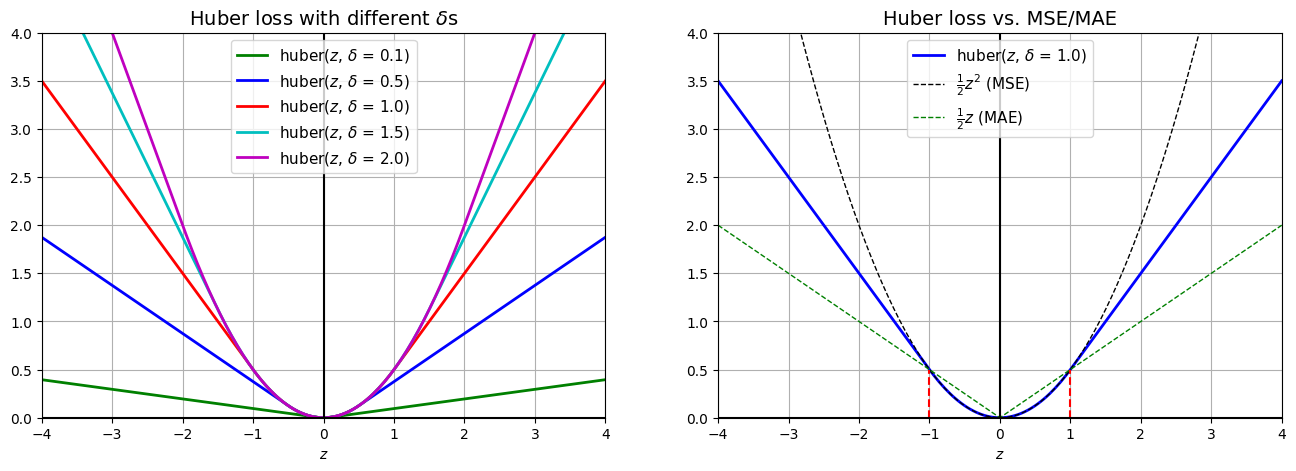

In [29]:
plt.figure(figsize=(16, 5))
z = np.linspace(-4, 4, 200)

#different threshold values 
plt.subplot(121)
plt.plot(z, huber(0, z, 0.1), "g-", linewidth = 2, label = "huber($z$, $\delta$ = 0.1)")
plt.plot(z, huber(0, z, 0.5), "b-", linewidth = 2, label = "huber($z$, $\delta$ = 0.5)")
plt.plot(z, huber(0, z, 1.0), "r-", linewidth = 2, label = "huber($z$, $\delta$ = 1.0)")
plt.plot(z, huber(0, z, 1.5), "c-", linewidth = 2, label = "huber($z$, $\delta$ = 1.5)")
plt.plot(z, huber(0, z, 2.0), "m-", linewidth = 2, label = "huber($z$, $\delta$ = 2.0)")
plt.gca().axhline(y = 0, color = "k")
plt.gca().axvline(x = 0, color = "k")
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize = 11)
plt.title("Huber loss with different $\delta$s", fontsize = 14)

# different losses, huber delta = 1 
plt.subplot(122)
plt.plot(z, huber(0, z, 1.0), "b-", linewidth = 2, label = "huber($z$, $\delta$ = 1.0)")
plt.plot(z, z**2 / 2, "k--", linewidth = 1, label = r"$\frac{1}{2}z^2$ (MSE)")
plt.plot(z, tf.abs(z) / 2, "g--", linewidth = 1, label = r"$\frac{1}{2}z$ (MAE)")
plt.plot([-1, -1], [0, huber(0., -1.)], "r--")
plt.plot([1, 1], [0, huber(0., 1.)], "r--")
plt.gca().axhline(y = 0, color = "k")
plt.gca().axvline(x = 0, color = "k")
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize = 11)
plt.title("Huber loss vs. MSE/MAE", fontsize = 14)
plt.show()

In [72]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer="lecun_normal",
                       input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = huber, optimizer="nadam", metrics = ['mae'])
model.fit(X_train, y_train, epochs = 2, validation_data = (x_val, y_val), verbose = 1)
# model.save("model.h5")

Epoch 1/2
363/363 [==============================] - 4s 11ms/step - loss: 0.7120 - mae: 1.0858 - val_loss: 369.0554 - val_mae: 369.5554
Epoch 2/2
363/363 [==============================] - 4s 10ms/step - loss: 0.2354 - mae: 0.5337 - val_loss: 346.7939 - val_mae: 347.2939


To load a model with custom objects, the custom objects need to be mapped manually: 

```python
model = keras.models.load_model("model.h5", custom_objects = {"object_name": object})
```

In [ ]:
# if we want to switch to a different threshold for huber loss: 

# load_model("model.h5")

def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

# model.compile(loss = create_huber(2.0))
# model.fit()
# model.save("huber_2_model.h5")
# keras.models.load_model("huber_2_model.h5",       
#                         custom_objects = {"huber_fn": create_huber(2.0)})

The abovementioned method will not save the threshold value when the model is saved. To save the model with configuration, use the sub-classing method: 

In [33]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold = 1.0, **kwargs) :
        # **kwargs accepts arguments and pass them to parent constructor (the standard hyperparams)
        self.threshold = threshold
        super().__init__()
     
    def call(self, y_true, y_pred):
        # takes y_true and y_pred, calculates loss, and return them
        err = y_true - y_pred
        is_small_err = tf.abs(err) < self.threshold 
        squared_loss = tf.square(err) / 2
        linear_loss = self.threshold * tf.abs(err) - self.threshold**2/2
        return super().call(y_true, y_pred)
    
    def get_config(self):
        # returns a dictionary mapping of each hyperparameter name to its value
        base_config = super().get_config()
        #       ┌--> dictionary unpacking 
        return {**base_config, "threshold": self.threshold}

Then, the instance of `HuberLoss` can be used when compiling the model: 
`model.compile(loss = HuberLoss(2.), optimizer = "nadam")` as well as loading a saved model: `keras.models.load_model("huber_subclass_model.h5", custom_objects = {"HuberLoss": HuberLoss})`

## Custom activation functions, initialiers, regularizers, and constraints

Most keras functions can be customized through implementing a simple function with appropriate inputs and outputs. However, when a parameter needs to be saved, one should use subclassing technique to implement the function

In [ ]:
# define functionalities using simple functions
def softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def glorot_normal_init(shape, dtype = tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev = stddev, dtype = dtype)

def l1_reg(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

# use custom functionalities in layers: 
keras.layers.Dense(30, activation=softplus,
                   kernel_initializer=glorot_normal_init,
                   kernel_regularizer=l1_reg,
                   kernel_constraint=positive_weights)

# saving can be done with .save()
# loading is as follows: 
model = keras.models.load_model("my_model.h5",
                                custom_objects={
                                    "l1_reg": l1_reg,
                                    "softplus": softplus,
                                    "glorot_normal_init": glorot_normal_init,
                                    "positive_weights": positive_weights
                                })

In [ ]:
# define functionalities using subclassing
class L1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor) -> None:
        self.factor = factor
    
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {"factor": self.factor}
    
# same with custom objects defined through simple functions, include the class name
# in custom_objects argument dictionary when loading the model

## Custom Metrics

- Losses must be differentiable (since they are used in training), while metrics do not necessarily have to be differentiable but need to be interpretable. 
- (?)**streaming metrics** - During training, Keras computes the metric and keeps track of its mean since the beginning of each epoch. However, if the mean is applied to the batch level and not instance level, this could lead to incorrect results. Therefore, we need an object to keep track of metrics on an instance (data point?) level.

> The loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
> The metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. 

- Sometimes, a loss can also be used as a metric. However, since operations may not be carried out in the same order, and that there may be numerical precision errors, the same function can yield different results. Using sample weights can also lead to the same issue. 

In [6]:
# streaming metrics 

precision = keras.metrics.Precision()

# first batch 
precision([0, 1, 1, 1, 0, 1, 0, 1],
          [1, 1, 0, 1, 0, 1, 0, 1])

# second batch 
precision([0, 1, 0, 0, 1, 0, 1, 1],
          [1, 0, 1, 1, 0, 0, 0, 0])

# get overall results and variables (keeps track of true positives and false positives)
precision.result(), precision.variables

# reset state of the variable
# precision.reset_state()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.5>,
 [<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
  <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>])

In [ ]:
# streaming metric + subclasing 

class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        # use add_weight to add variables to be tracked , but can be replaced with 
        # other tf Variables or layers
        self.total = self.add_weight("total", initializer = "zeros")
        self.count = self.add_weight("count", initializer = "zeros")

    def update_state(self, y_true, y_pred, *args, **kwargs):
        # called when the class is used as a function
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()

## Custom layers

1. For layers without weights (e.g., ReLU, Flatten): use `keras.layers.Lambda`.
     - E.g., the exponential layer would be expressed as: `tf.keras.layers.Lambda(lambda x: tf.exp(x))`
2. For layers with weights: use subclassing as shown below: 

In [ ]:
class MyDense(keras.layers.Layer):
    """a simple implementation of Dense layer using subclassing"""

    def __init__(self, units, activation=None, dynamic=False, **kwargs):
        # name, trainable, input_shape are handled through **kwargs
        super().__init__(**kwargs)
        self.units = units
        # accepts strings and get corresponding activation functions
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=[input_shape[-1], self.units],
            initializer="glorot_normal",
        )
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros"
        )
        return super().build(input_shape)  # sets self.built to True

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, input_shape):
        # shape of tensors are usually expressed as TensorShape
        # can generally be omitted
        return tf.TensorShape(input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "units": self.units,
            "activation": keras.activations.serialize(self.activation),
        }

X1.shape:  (None, 2)  X2.shape:  (None, 2)


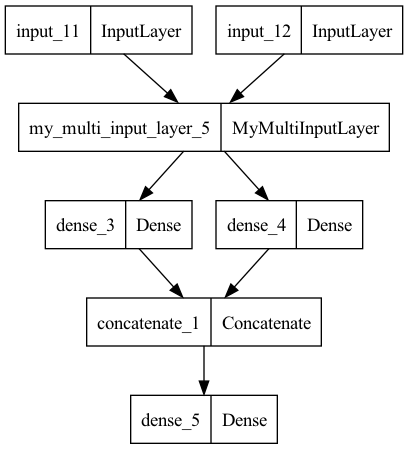

In [8]:
class MyMultiInputLayer(keras.layers.Layer):
    """Implementation of layers with multiple inputs"""
    def call(self, X:tuple):
        """
        Args:
            X (tuple): X must be a tuple containing the inputs

        Returns:
            _type_: _description_
        """
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)
        return [X1 + X2, X1 * X2]
    
    def compute_output_shape(self, input_shape):
        b1 = input_shape
        return [b1, b1]

input_A = keras.layers.Input(shape=[2])
input_B = keras.layers.Input(shape=[2])
hidden_A, hidden_B = MyMultiInputLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

tf.keras.utils.plot_model(model=model)

In [10]:
# if the model needs to employ different behaviors during training: 
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self,stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training = None):
        if training: 
            noise = tf.random.normal(tf.shape(X), stddev = self.stddev)
            return noise 
        else:
            return X
    def compute_output_shape(self, input_shape):
        return input_shape
    
# to use this layer: 
model = keras.models.Sequential([
    MyGaussianNoise(stddev = 1.0),
    keras.layers.Dense(30, activation = "selu") 
])

## Custom models

It is noteworthy that `keras.models.Models` is a subclass of the `keras.layers.Layers` class. 

In [31]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation = "relu",
                                          kernel_initializer = "he_normal")
                      for i in range(n_layers)]
        
    def call(self, inputs):
        Z = inputs
        print(inputs)
        for layer in self.hidden:
            Z = layer(Z)
            print(layer, Z)
        return inputs + Z # concatenate input and 2 dense layers
    
inputs = keras.layers.Input(shape = [2])
res = ResidualBlock(2, 2)(inputs)

Tensor("Placeholder:0", shape=(None, 2), dtype=float32)
<keras.layers.core.dense.Dense object at 0x2984670d0> Tensor("residual_block_16/dense_56/Relu:0", shape=(None, 2), dtype=float32)
<keras.layers.core.dense.Dense object at 0x298466da0> Tensor("residual_block_16/dense_57/Relu:0", shape=(None, 2), dtype=float32)


In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation = "elu",
                                          kernel_initializer = "he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)
    
model = ResidualRegressor(1)

## Losses and metrics based on model internals

- To compute loss metrics internally within a model, use the `add_loss()` method.
- The following example implements reconstruction loss: associated to an auxilliary output at the upper hidden layer. This is the mean squared difference between the "reconstruction" and the inptus

In [ ]:
class ReconstructionLossRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation = "selu",
                                          kernel_initializer = "lecun_normal")
                      for i in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name = "reconstruction_error")
        
    def build(self, batch_input_shape):
        """create a dense layer to reconstruct input
        """
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        # super().build(batch_input_shape)
    
    def call(self, inputs, training = None):
       Z = inputs
       for layer in self.hidden:
           Z = layer(Z)
       reconstruction = self.reconstruct(Z)
       reconstruction_ls = tf.reduce_mean(tf.square(reconstruction - inputs))
       #              ┌─ hyperparam. Make sure reconstruction loss does not dominate main loss
       self.add_loss(0.05 * reconstruction_ls)
       if training: 
           result = self.reconstruction_mean(reconstruction_ls)
           self.add_metric(result)
       return self.out(Z)

## Compute gradients using autodiff

- We can use approximation method to compute the gradient of a function, but it is inefficient (function needs to be called once per parameter) in the context of large neural networks, where there are a lot of parameters that need to be tracked.
- Therefore, we can use tensorflow autodiff (`tf.GradientTape()`) to do partial derivatives. All the variables go through the gradient once, so it is efficient. 
- A few quirks of `tf.GradientTape()`: 
     1. By default, the gradient will be erased after calling `.gradient()`. To prevent this, use `persistent = True` in `tf.GradientTape()`
     2. By default, it only watches `tf.Variables`. To watch other types of values, call `tape.watch(var)` to watch it. 
     3. By default, when a vector of multiple value is passed to autodiff, it computes the gradients of the vector's sum. To do the computation separately on each individual values, use `tape.jacobian()`.


- Anatomy of gradient tapes:
```python

# 1. define gradient tape context manager 
with tf.GradientTape() as gt: 
   target = fn(source1, source2, ...)  
   
tf.gradient([target], [source1, source2, ...])
```

In [5]:
def f(w1, w2):
    """toy function, derivative is (36, 10) at (5, 3)"""
    return 3 * w1 ** 2 + 2 * w1 * w2

# compute approximation of the partial derivative by measuring 
# the changes in input when corresponding parameter is tweaked 
# however, this method can become intractable for large NNs
w1, w2, eps = 5, 3, 1e-6
((f(w1 + eps, w2) - f(w1, w2)) / eps,
 (f(w1, w2 + eps) - f(w1, w2)) / eps)

(36.000003007075065, 10.000000003174137)

In [8]:
# GradientTape
w1, w2 = tf.Variable(5.), tf.Variable(3.)

with tf.GradientTape() as gt: # automatically record operation that involves a variable
    z = f(w1, w2)
grad = gt.gradient(z, [w1, w2])
print(*grad)

tf.Tensor(36.0, shape=(), dtype=float32) tf.Tensor(10.0, shape=(), dtype=float32)


In [7]:
# the gradient is immediately erased after calling gradient()
# if the gradient needs to persist, use:
with tf.GradientTape(persistent=True) as pgt: 
    z = f(w1, w2)

In [31]:
# GradientTape() tracks Variables only by default
c1, c2 = tf.constant(5.), tf.constant(3.)

with tf.GradientTape() as gt:
    z = f(c1, c2)
grad = gt.gradient(z, [c1, c2])
print(f"default result: {grad}")

# use .watch to keep track of anything other than Variable()s
with tf.GradientTape() as gt:
    gt.watch(c1), gt.watch(c2)
    z = f(c1, c2)
grad = gt.gradient(z, [c1, c2])
print(f"After .watch(): {grad}")

default result: [None, None]
After .watch(): [<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


In [40]:
with tf.GradientTape() as default:
    # compute gradient as sum of target wrt to each source
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

print(default.gradient([z1, z2, z3], [w1, w2]))

with tf.GradientTape(persistent = True) as manual:
    # compute gradient separately and sum them up
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
print(tf.reduce_sum(tf.stack([manual.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis = 0))

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>, <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]
tf.Tensor([136.  30.], shape=(2,), dtype=float32)


In [48]:
with tf.GradientTape(persistent=True) as hessian:
    with tf.GradientTape() as jacobian: 
        z = f(w1, w2)
    jacobians = jacobian.gradient(z, [w1, w2])
hessians = [hessian.gradient(jacobians, [w1, w2]) for j in jacobians]

print(f"{'='*10}Jacobian{'='*10}\n{jacobians}\n{'='*10}Hessian{'='*10}\n{hessians}")

==========Jacobian==========
[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]
==========Hessian==========
[[<tf.Tensor: shape=(), dtype=float32, numpy=8.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>], [<tf.Tensor: shape=(), dtype=float32, numpy=8.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>]]


In [11]:
with tf.GradientTape() as jgt: 
    z = f(w1, w2) 
jacobian = jgt.jacobian(z, [w1, w2])
jacobian

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

When we want to stop the gradient from backpropagating during training, use `tf.stop_gradient()` function.

In [34]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as gt:
    z = f(w1, w2)

gradients = gt.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In some cases, autodiff can run into some numerical issues. For example, computing the gradient of the softplus function gives `nan` results. This is caused by infinity dividing by infinity in autodiff float-point precision errors (caused by the exponential operation on the numeric values). 

In [47]:
x1 = tf.Variable([100.])
x2 = tf.Variable([1000.])
# numerically unstable
with tf.GradientTape() as tape:
    z = softplus([x1])

nan_grad = tape.gradient(z, [x1]) # gives nan
print(nan_grad)

# numerically stable version of softplus (derivative of softplus)
@tf.custom_gradient
def softplus_stable_1(z):
    exp = tf.exp(z)
    def softplus_grad(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), softplus_grad

def softplus_stable_2(z):
    """returns the original value when the value is large (avoid exponential operation)"""
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

with tf.GradientTape(persistent = True) as tape:
    z = softplus_stable_1(x1)
    zz = softplus_stable_2(x2)

stable_grad1 = tape.gradient(z, [x1])
stable_grad2 = tape.gradient(zz, [x2])
print(stable_grad1, stable_grad2)

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]
[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>] [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]


## Custom training loops

- Models does not need to be `.compile()`ed when defining custom training loops

In [49]:
# define model
l2_reg = keras.regularizers.l2(0.05)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "elu", 
                       kernel_initializer="he_normal",
                       kernel_regularizer = l2_reg),
    keras.layers.Dense(1, kernel_regularizer = l2_reg)
])

In [61]:
# define random selection of train/test data
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(len(X), size = batch_size)
    return X[idx], y[idx]

# define status bar function
def stat_bar(iteration, total, loss, metrics:list = None):
    metrics = " - ".join([f"{m.name}:{m.result():.4f}" for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print(f"\r{iteration}/{total} - " + metrics, end = end)

mean_loss = keras.metrics.Mean(name = "loss")
mean_square = keras.metrics.Mean(name = "mean_square")

for i in range(1, 50+1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(1 ** 2)
    stat_bar(i, 50, mean_loss, [mean_square])

50/50 - loss:0.0900 - mean_square:1.0000


In [2]:
# advanced version (progress bar)
def progress_bar(iteration, total, size = 30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)
progress_bar(3500, 10000)

' 3500/10000 [==========>...................]'